In [1]:
import sys
import os
import astropy.io.fits as fits
import math
import os.path
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
# import matplotlib as plt
import os.path
import glob
import matplotlib.pyplot as plt
import operator
from matplotlib.colors import LogNorm
from photutils.datasets import make_4gaussians_image
from photutils import centroid_com, centroid_1dg, centroid_2dg
import numpy as np
from astropy.visualization import PercentileInterval
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn

In [2]:
# definitions
def slicing_im(npix,box):
    npix = npix #total pixels
    box = box #changes the display of arrays
    result= (npix - box)/2
#     print(result)
#     print(result)
    if result % 1 == 0:
        end_num = int(result)
        strt_num = end_num
        new_st = strt_num
        new_end = npix - end_num
    else:
#         end_num = int(round(result,0))
        end_num = result +0.5
        strt_num = end_num - 1
        new_st = strt_num 
        new_end = npix - end_num
#     print("total pixels is: ",npix,'\nLeft side start by:',new_st,"\nRight side end by:",new_end)
    strt = int(new_st)
    end = int(new_end)
    return strt, end

def scale_image(scale,time, data_image):
    scale_num = scale
    interval = PercentileInterval(scale_num)
    interval.get_limits(data_image[time,:,:])
    scale_array = interval(data_image[time,:,:])
    return scale_array 

def diff_arr(array):
    new_array = []
    for i in range(len(array)):
        result = array[i]-i-1
        new_array.append(result)
    return new_array

def aperture_sum(radius, data, val_x, val_y):
    R = radius
    val_2dg_x = val_x
    val_2dg_y = val_y
    # for positions we will take the 2dg Gaussian outputs.
    positions = [(val_2dg_x, val_2dg_y)]
    apertures = CircularAperture(positions, r=R)
    # print(apertures)
    phot_table = aperture_photometry(data,apertures)
    return phot_table['aperture_sum']


In [3]:
tot_dir_bcd = ['/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_1',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_2',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_3',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_4',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_5',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_6-1',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_6-2',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_7',]


In [187]:
#Opening the file
# test with one bcd file

dir_bcd ='/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_1/SPITZER_I1_50037760_0000_0000_2_bcd.fits'
# dir_bcd ='/Users/Name_of_Student/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_2/SPITZER_I2_50038016_0000_0000_2_bcd.fits'
# dir_bcd='/Users/Name_of_Student/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_3/SPITZER_I1_50038272_0000_0000_2_bcd.fits'

fits_file = fits.open(dir_bcd)

## displays HDUL types within the fits file.
fits_data = get_pkg_data_filename(dir_bcd)

image_data= fits.getdata(fits_data, ext=0)

list_Primary = fits_file[0]

fits.info(fits_data)
list_Primary.header



Filename: /Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_1/SPITZER_I1_50037760_0000_0000_2_bcd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     673   (32, 32, 64)   float32   


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
NAXIS   =                    3 / STANDARD FITS FORMAT                           
NAXIS1  =                   32 / STANDARD FITS FORMAT                           
NAXIS2  =                   32 / STANDARD FITS FORMAT                           
NAXIS3  =                   64 / STANDARD FITS FORMAT                           
ORIGIN  = 'Spitzer Science Center' / Organization generating this FITS file     
CREATOR = 'S19.2.0 '           / SW version used to create this FITS file       
TELESCOP= 'Spitzer '           / SPITZER Space Telescope                        
INSTRUME= 'IRAC    '           / SPITZER Space Telescope instrument ID          
CHNLNUM =                    1 / 1 digit instrument channel number              
EXPTYPE = 'sci     '           / Exposure Type                                  
REQTYPE = 'AOR     '        

In [5]:
## pulls out specific information when needed.
frame_t = fits_file[0].header['FRAMTIME']
print('Frame Time:',frame_t)

bmjd_obs = fits_file[0].header['BMJD_OBS']
print('bmjd observation:', bmjd_obs)

flux_conv= fits_file[0].header['FLUXCONV']
print('Flux Conversion',flux_conv)

gain = fits_file[0].header['GAIN']
print('Gain',gain)

exp_time= fits_file[0].header['EXPTIME']
print('Exp-time', exp_time)

conversion_factor = gain*exp_time/flux_conv
print(conversion_factor)

counts_image = image_data * conversion_factor


Frame Time: 2.0
bmjd observation: 56781.095898
Flux Conversion 0.1257
Gain 3.7
Exp-time 1.92
56.51551312649165


In [6]:
i = 0
j_final = 63

frameday = frame_t/(3600*24)
shift_bmjd = bmjd_obs + 0.5* frameday
# print(shift_bmjd)
list_bmjd =[shift_bmjd]
# print(list_bmjd[0])
# Adding
for j in range(j_final):
    value = list_bmjd[0] + (j+1)*frameday
    list_bmjd.append(value)


In [7]:
# definitions
def slicing_im(npix,box):
    npix = npix #total pixels
    box = box #changes the display of arrays
    result= (npix - box)/2
#     print(result)
#     print(result)
    if result % 1 == 0:
        end_num = int(result)
        strt_num = end_num
        new_st = strt_num
        new_end = npix - end_num
    else:
#         end_num = int(round(result,0))
        end_num = result +0.5
        strt_num = end_num - 1
        new_st = strt_num 
        new_end = npix - end_num
#     print("total pixels is: ",npix,'\nLeft side start by:',new_st,"\nRight side end by:",new_end)
    strt = int(new_st)
    end = int(new_end)
    return strt, end
print(slicing_im(32,7))
# slicing_im(32,7)


def scale_image(scale,time, data_image):
    scale_num = scale
    interval = PercentileInterval(scale_num)
    interval.get_limits(data_image[time,:,:])
    scale_array = interval(data_image[time,:,:])
    return scale_array

(12, 19)


12 19
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.2370198341948173 3.2541745450187602
      15.737019834194818 15.75417454501876
2dG:  3.1813711742139237 3.1965485875604625
      15.681371174213924 15.696548587560462


/anaconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.2371219109538023 3.26153579439231
      15.737121910953803 15.76153579439231
2dG:  3.1884277590435675 3.199540040474066
      15.688427759043567 15.699540040474066
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.24129476226384 3.2614592690449937
      15.74129476226384 15.761459269044995
2dG:  3.1871448431273532 3.2023974317032984
      15.687144843127353 15.702397431703298
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.2410508638685 3.2635714217308407
      15.7410508638685 15.763571421730841
2dG:  3.1881720683282393 3.202389603890292
      15.688172068328239 15.702389603890293
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.239818501939786 3.265761343785936
      15.739818501939785 15.765761343785936
2dG:  3.189311773003587 3.20002733841812
      15.689311773003586 15.70002733841812
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.2425807344987363 3.2658849049731367
      15.742580734498736 15.765884904973136
2dG:  3.193381239224765 3.2

7 12 19
Box Size:  7 x 7
COM:  3.190233086406972 3.3062701600494586
      15.690233086406971 15.806270160049458
2dG:  3.21983592115902 3.150509168455495
      15.71983592115902 15.650509168455494
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.1863388369104895 3.3081425442963064
      15.68633883691049 15.808142544296306
2dG:  3.2230454640112645 3.147921988970136
      15.723045464011264 15.647921988970136
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.1782742118604466 3.298343318047753
      15.678274211860447 15.798343318047753
2dG:  3.215927065837053 3.1429531174399097
      15.715927065837054 15.642953117439909
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.188436544792848 3.2978369220472343
      15.688436544792848 15.797836922047235
2dG:  3.21487836739941 3.1480627998713686
      15.714878367399411 15.648062799871369
delta x/y:12.5
7 12 19
Box Size:  7 x 7
COM:  3.1881574120184184 3.3007333815114697
      15.688157412018418 15.80073338151147
2dG:  3.2197486685740118 3.149330673

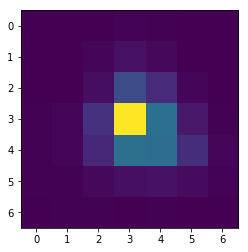

In [40]:
cen_2dg_x=[]
cen_2dg_y=[]
cen_com_x=[]
cen_com_y=[]
centroid_com_arr_x = []
centroid_com_arr_y = []
centroid_2dG_arr_x = []
centroid_2dG_arr_y = []
num = 0
time_i = 1
scale_num = 100
npix = 32
i_box = 7 #sub box
strt, end = slicing_im(npix,i_box)
print(strt,end)

for time_i in range(0,64):        
    interval = PercentileInterval(scale_num) ###
    interval.get_limits(counts_image[time_i,strt:end,strt:end])
    scale_array = interval(counts_image[time_i,strt:end,strt:end])
#     sliced_image = counts_image[0,strt:end,strt:end] 
    result = scale_array
    
    print('delta x/y:'+str(12.5))
#     if i_box == 7:
    x1, y1 = centroid_com(result)
    x2, y2 = centroid_2dg(result)

    x_delta_1 = (npix-i_box)/2
    y_delta_1 = (npix-i_box)/2
    xc_1 = x_delta_1+ x1
    yc_1 = y_delta_1+ y1

    x_delta_2 = (npix-i_box)/2
    y_delta_2 = (npix-i_box)/2
    xc_2 = x_delta_2+ x2
    yc_2 = y_delta_1+ y2

    print(i_box,strt,end)
    print('Box Size: ', i_box,'x',i_box)
    print('COM: ',x1,y1)
    print('     ',xc_1,yc_1)
    print('2dG: ',x2,y2)
    print('     ',xc_2,yc_2)

    centroid_com_arr_x.append(x1)
    centroid_com_arr_y.append(y1)
    centroid_2dG_arr_x.append(x2)
    centroid_2dG_arr_y.append(y2)

    cen_com_x.append(xc_1) #adds the offset of the full set.
    cen_com_y.append(yc_1)
    cen_2dg_x.append(xc_2)
    cen_2dg_y.append(yc_2)
    num = num+1
#     print(num,time_i,'\n')
    plt.imshow(result)
#     plt.show()


In [9]:
#//--------------------------------------------------------------------------------
## //Original bottom code for both 2dc and com
def org_dict(dict_name,str_num_name,com_x,com_y,dg_x,dg_y):
    start_ind =0 
    end_ind = 1
    str_arr_list = ["cen_com_arr_x", "cen_com_arr_y","cen_2dg_arr_x","cen_2dg_arr_y"]
    dict_cen = dict_name
# puts each into a seperate array of 15 indexes
    for i in range(0,64):
        dict_cen[str_arr_list[0]+'_'+str(i)] = com_x[start_ind:end_ind]
        dict_cen[str_arr_list[1]+'_'+str(i)] = com_y[start_ind:end_ind]
        dict_cen[str_arr_list[2]+'_'+str(i)] = dg_x[start_ind:end_ind]
        dict_cen[str_arr_list[3]+'_'+str(i)] = dg_y[start_ind:end_ind]
        start_ind = start_ind + 1
        end_ind = end_ind+1
#creates an array of numbered names.
    str_num_arr=str_num_name
    for j in range(0,64):
        str_name_1 = str_arr_list[0]+'_'+str(j)
        str_name_2 = str_arr_list[1]+'_'+str(j)
        str_name_3 = str_arr_list[2]+'_'+str(j)
        str_name_4 = str_arr_list[3]+'_'+str(j)
        str_num_arr.append(str_name_1)
        str_num_arr.append(str_name_2)
        str_num_arr.append(str_name_3)
        str_num_arr.append(str_name_4)

str_num_arr=[]      
dict_cen = {}
# org_dict(dict_cen,str_num_arr,centroid_com_arr_x,centroid_com_arr_y,centroid_2dG_arr_x,centroid_2dG_arr_y)
org_dict(dict_cen,str_num_arr,cen_com_x,cen_com_y,cen_2dg_x,cen_2dg_y)

In [10]:
# len(centroid_com_arr_x)

# print(str_num_arr)
# print(dict_cen)
# print(dict_cen[str_num_arr[0]][0])

# xy=1
# print(dict_cen['cen_com_arr_x_'+str(xy)][0])
# print(dict_cen['cen_com_arr_y_'+str(xy)][0])
# print(dict_cen['cen_2dg_arr_x_'+str(xy)][0])
# print(dict_cen['cen_2dg_arr_y_'+str(xy)][0])

# dict_cen
# str_num_arr

# print(dict_cen[str_num_arr[0]][1])



# str_num_arr

In [11]:
r_1 = 7
r_2 = 11
r_3 = 14
# # 8,13,23
h_2dg = 0 ## starting index for 2dG
index_box = 0 #Box size is 7x7.
photometry_arr =[]
for l in range(0,64):
    aperture_1 = aperture_sum(r_1,counts_image[l,:,:], dict_cen[str_num_arr[h_2dg]][index_box], dict_cen[str_num_arr[h_2dg+1]][index_box]) 
    aperture_2 = aperture_sum(r_2,counts_image[l,:,:], dict_cen[str_num_arr[h_2dg]][index_box], dict_cen[str_num_arr[h_2dg+1]][index_box])
    aperture_3 = aperture_sum(r_3,counts_image[l,:,:], dict_cen[str_num_arr[h_2dg]][index_box], dict_cen[str_num_arr[h_2dg+1]][index_box])
    
    print(str_num_arr[h_2dg],str_num_arr[h_2dg+1])
    print(dict_cen[str_num_arr[h_2dg]][index_box],dict_cen[str_num_arr[h_2dg+1]][index_box])
    
#     print(aperture_1,aperture_2,aperture_3,'\n')
## Area of aperture,
    area_1 = math.pi * r_1**2

## Background in annulus from r_2 to r_3
    background_counts = aperture_3 - aperture_2

## Area of Annulus
    area_2 = math.pi*(r_3**2 - r_2**2) #also known as npix

## subtracting background: 
    backgrnd_subtract = aperture_1 - background_counts*area_1/area_2
    photometry_arr.append(backgrnd_subtract)

    h_2dg = h_2dg+4


#  final aperture photometry value of the time index
print(photometry_arr)

# #-------------------------------------------------------------------------------------------------





cen_com_arr_x_0 cen_com_arr_y_0
15.737019834194818 15.75417454501876
cen_com_arr_x_1 cen_com_arr_y_1
15.737121910953803 15.76153579439231
cen_com_arr_x_2 cen_com_arr_y_2
15.74129476226384 15.761459269044995
cen_com_arr_x_3 cen_com_arr_y_3
15.7410508638685 15.763571421730841
cen_com_arr_x_4 cen_com_arr_y_4
15.739818501939785 15.765761343785936
cen_com_arr_x_5 cen_com_arr_y_5
15.742580734498736 15.765884904973136
cen_com_arr_x_6 cen_com_arr_y_6
15.736644951179839 15.76043340923137
cen_com_arr_x_7 cen_com_arr_y_7
15.727802738451233 15.764565350649976
cen_com_arr_x_8 cen_com_arr_y_8
15.737667053565605 15.761793991746666
cen_com_arr_x_9 cen_com_arr_y_9
15.744903332429205 15.764891973319564
cen_com_arr_x_10 cen_com_arr_y_10
15.745360887530833 15.76549320841635
cen_com_arr_x_11 cen_com_arr_y_11
15.739320480250889 15.763610862576195
cen_com_arr_x_12 cen_com_arr_y_12
15.732579333678581 15.769553286230817
cen_com_arr_x_13 cen_com_arr_y_13
15.738435918800555 15.76502100731198
cen_com_arr_x_14 cen

In [12]:
class fullprint:
    'context manager for printing full numpy arrays'
    def __init__(self, **kwargs):
        kwargs.setdefault('threshold', np.inf)
        self.opt = kwargs

    def __enter__(self):
        self._opt = np.get_printoptions()
        np.set_printoptions(**self.opt)

    def __exit__(self, type, value, traceback):
        np.set_printoptions(**self._opt)

In [207]:
fits_file = fits.open(dir_bcd)
# displays HDUL types within the fits file.
fits_data = get_pkg_data_filename(dir_bcd)
# fits.info(fits_data)
list_Primary = fits_file[0]
# list_Primary.header
image_data= fits.getdata(fits_data, ext=0)


# plt.imshow(image_data[0,12:19,12:19])
# plt.imshow(image_data[0,:,:])

# print(image_data[0,:,:][15][16])
# tst=image_data[0,:,:]
# tst[15][15]
# plt.imshow(tst)
# strt, end = slicing_im(32,7)
# print(strt,end)

print(image_data[0,:,:][0][0])

# with fullprint():
#     print(image_data[0,strt:end,strt:end])
#     print(image_data[0,:,:])

# pull out only a single value



# print(strt,end)
# plt.imshow(image_data[0,strt:end,strt:end])
# plt.imshow(image_data[0,12:19,12:19])

-3.0942957


In [165]:
h_2dg=2

aperture_1 = aperture_sum(2,image_data[0,:,:],dict_cen[str_num_arr[h_2dg]][0],dict_cen[str_num_arr[h_2dg+1]][0]) 
print(aperture_1)

# print(dict_cen[str_num_arr[h_2dg]][0])
u=.5
aperture_1 = aperture_sum(2,image_data[0,:,:],dict_cen[str_num_arr[h_2dg]][0]-u,dict_cen[str_num_arr[h_2dg+1]][0]-u) 
print(aperture_1)



   aperture_sum  
-----------------
6290.098263295908
   aperture_sum  
-----------------
6518.120553308173


In [189]:
h_2dg=0

# print(str_num_arr[h_2dg],str_num_arr[h_2dg+1])
# print(dict_cen[str_num_arr[h_2dg]][0],dict_cen[str_num_arr[h_2dg+1]][0])
# print(time_i)
x2, y2 = centroid_2dg(image_data[time_i,:,:])
# print(x2,y2)


# strt, end = slicing_im(32,7)
# print(strt,end)
# scale_array = interval(image_data[0,12:19,12:19])
# plt.imshow(scale_array)
# plt.plot(scale_array)
# x1, y1 = centroid_2dg(scale_array)##7x7
print(x1,y1) 
numtst = (32-7)/2-.5
print(numtst)
print(x1+numtst,y1+numtst)##what we want



3.1813711596575227 3.1965485740909463
12.0
15.181371159657523 15.196548574090947


/anaconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


In [162]:

# definitions
# def slicing_im(npix,box):
npix = 32 #total pixels
box = 7 #changes the display of arrays
result= (npix - box)/2
print('result: ',result)
if result % 1 == 0:
    end_num = int(result)
    strt_num = end_num
#         print(strt_num,end_num)
    new_st = strt_num
    new_end = npix - end_num
#         print(new_st,new_end)
else:
#     end_num = int(round(result,0))
#     print(end_num)
    end_num = result +0.5
#     print(end_num)
    strt_num = end_num - 1
#     print(strt_num)
#         print(end_num,strt_num)
    new_st = strt_num 
    new_end = npix - end_num
    print("total pixels is: ",npix,'\nLeft side start by:',new_st,"\nRight side end by:",new_end)
strt = int(new_st)
end = int(new_end)
#     return strt, end

strt, end = slicing_im(32,7)
# print(strt,end)
scale_array = interval(image_data[time_i,strt:end,strt:end])

result:  12.5
total pixels is:  32 
Left side start by: 12.0 
Right side end by: 19.0


In [33]:
x1, y1 = centroid_2dg(scale_array)



/anaconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


In [34]:
x1,y1


    
#         index = 1
#         ipsv = p[0]
        
#         for i in range(maxorder):
#             order=i+1
#             loop_order=i+2
#             for j in range(loop_order):
#                 ipsv=ipsv+p[index]*(x-x_bar)**(order-j)*(y-y_bar)**(j)
#                 index=index+1
        

#         fourier = p[index+1]
#         for i in range(nmodes):
#             n=i+1
#             fourier = fourier + p[2+i*2]*np.cos(2.*np.pi*n*t/p[0]) + p[3+i*2]*np.sin(2.*np.pi*n*t/p[0])
       

(3.231508483347484, 3.1868073227371694)